In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [115]:
file_path = 'database_2025-05-18.csv'  
df = pd.read_csv(file_path, low_memory=False)

In [116]:
wt_plates = ['99','99v1','99v3']
phase2_99= df[df['plate'].isin(wt_plates)]

In [117]:
# drop last data point
y2_cols = [f'y2_{i}' for i in range(1, 91)] 
def drop_last_valid(row):
    valid = row[y2_cols].last_valid_index()
    # if pd.notna(row[valid]):
    if valid is not None and pd.notna(row[valid]):
        row[valid] = np.nan
    return row

phase2_99 = phase2_99.apply(drop_last_valid, axis=1)

In [42]:
# Get y2_ columns
y2_cols = [col for col in df.columns if col.startswith('y2_')]

# Work on all WT plates
subset = phase2_99.copy()

# Identify first null y2_ column for each row
subset['first_null_y2'] = subset[y2_cols].isnull().idxmax(axis=1)

# Keep only rows that have at least one null in y2_ columns
subset['has_null'] = subset[y2_cols].isnull().any(axis=1)
subset = subset[subset['has_null']]

# Group by plate, light_regime, and first null column
summary = (
    subset.groupby(['plate', 'light_regime', 'first_null_y2'])
    .size()
    .reset_index(name='count')
    .sort_values(['plate', 'light_regime', 'count'], ascending=[True, True, False])
)

summary


,plate,light_regime,first_null_y2,count
0,99,10min-10min,y2_81,766
1,99,10min-10min,y2_85,766
2,99,1min-1min,y2_81,766
3,99,1min-1min,y2_89,383
4,99,1min-5min,y2_89,383
5,99,20h_HL,y2_41,383
6,99,20h_ML,y2_41,383
7,99,20h_ML,y2_45,383
8,99,2h-2h,y2_41,383
9,99,2h-2h,y2_49,383


In [118]:
## drop phase1 data in 99
phase2_99_1 = phase2_99.copy()

# Get y2 columns
y2_cols = [col for col in subset.columns if col.startswith('y2_')]

# Find the first column with null per row
phase2_99_1['first_null_y2'] = phase2_99_1[y2_cols].isnull().idxmax(axis=1)

# Drop rows where first null is y2_42 or y2_82
phase2_99_1= phase2_99_1[~phase2_99_1['first_null_y2'].isin(['y2_41', 'y2_81'])]


In [119]:
phase2_99_1['plate'] = phase2_99_1['plate'].replace('99', '99v2')


In [120]:
mask = (phase2_99_1['light_regime'] == '10min-10min') & (phase2_99_1['plate'] == '99v2')

phase2_99_1.loc[mask & (phase2_99_1['start_date'] == '2024-05-25'), 'plate'] = '99v2_2'
phase2_99_1.loc[mask & (phase2_99_1['start_date'] == '2024-11-22'), 'plate'] = '99v2_1'

In [143]:
phase2_99_1.shape

(8809, 727)

In [151]:
phase2_99_2 = phase2_99_1[~(phase2_99_1['mutant_ID'].isnull() & phase2_99_1['mutated_genes'].isnull())]
print(phase2_99_2.shape)
phase2_99_2=phase2_99_2[phase2_99_2['y2_1'].notnull()]

(8801, 727)


In [149]:
phase2_99_2.shape

(8787, 727)

In [44]:
# Get y2_ columns
y2_cols = [col for col in df.columns if col.startswith('y2_')]

# Work on all WT plates
subset = phase2_99_1.copy()

# Identify first null y2_ column for each row
subset['first_null_y2'] = subset[y2_cols].isnull().idxmax(axis=1)

# Keep only rows that have at least one null in y2_ columns
subset['has_null'] = subset[y2_cols].isnull().any(axis=1)
subset = subset[subset['has_null']]

# Group by plate, light_regime, and first null column
summary = (
    subset.groupby(['plate', 'light_regime', 'first_null_y2'])
    .size()
    .reset_index(name='count')
    .sort_values(['plate', 'light_regime', 'count'], ascending=[True, True, False])
)

summary

,plate,light_regime,first_null_y2,count
0,99,10min-10min,y2_85,766
1,99,1min-1min,y2_89,383
2,99,1min-5min,y2_89,383
3,99,20h_ML,y2_45,383
4,99,2h-2h,y2_49,383
5,99,30s-30s,y2_89,383
7,99v1,10min-10min,y2_85,382
6,99v1,10min-10min,y2_1,1
8,99v1,1min-1min,y2_89,383
10,99v1,1min-5min,y2_89,381


In [153]:
phase2_df1= pd.concat([phase2_df, phase2_99_2], axis=0)


In [154]:
phase2_df1.shape

(34808, 727)

In [155]:
phase2_df1.to_csv('phase2_99_df2(5.18)_newplate.csv',index=False)

In [156]:
phase2_df_new=phase2_df1.copy()
measurement_cols = [f'measurement_time_{i}' for i in range(91)]  
parsed_times = phase2_df_new[measurement_cols].apply(
    pd.to_datetime,
    errors='coerce'  
)

for i, col in enumerate(measurement_cols):
    phase2_df_new[f'elapsed_time_{i}'] = (parsed_times[col] - parsed_times['measurement_time_0']).dt.total_seconds() / 3600

In [178]:
phase2_df_new.shape

(34808, 820)

## slope compute

In [179]:
def add_y2_slope_and_intercept(hdata):
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(0, 88)]
    response_columns = [f'y2_{i}' for i in range(1, 89)]

    def compute_regression(row):
        time_values = row[time_columns].values.astype(float)
        y_values = row[response_columns].values.astype(float)
        # mask = ~np.isnan(y_values)
        mask = ~np.isnan(y_values) & ~np.isnan(time_values)


        if mask.sum() >= 2:
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])

            return pd.Series({
                'y2_slope': model.coef_[0],
                'y2_intercept': model.intercept_
            })
        return pd.Series({'y2_slope': np.nan, 'y2_intercept': np.nan})

    # Apply regression row-wise
    hdata[['y2_slope', 'y2_intercept']] = hdata.apply(compute_regression, axis=1)
    
    return hdata

In [180]:
phase2_df_new=add_y2_slope_and_intercept(phase2_df_new)

In [181]:
# Separate WT and mutants
wt_df = phase2_df_new[phase2_df_new['mutant_ID'] == 'WT']
mutant_df = phase2_df_new[phase2_df_new['mutant_ID'] != 'WT']

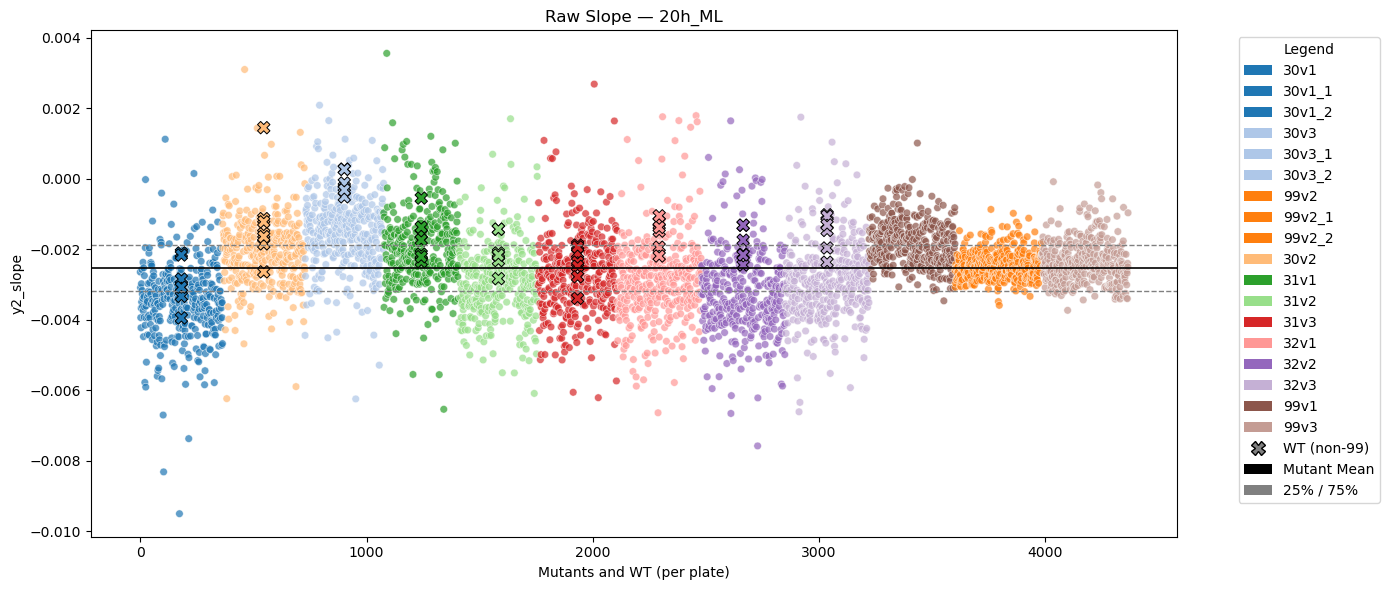

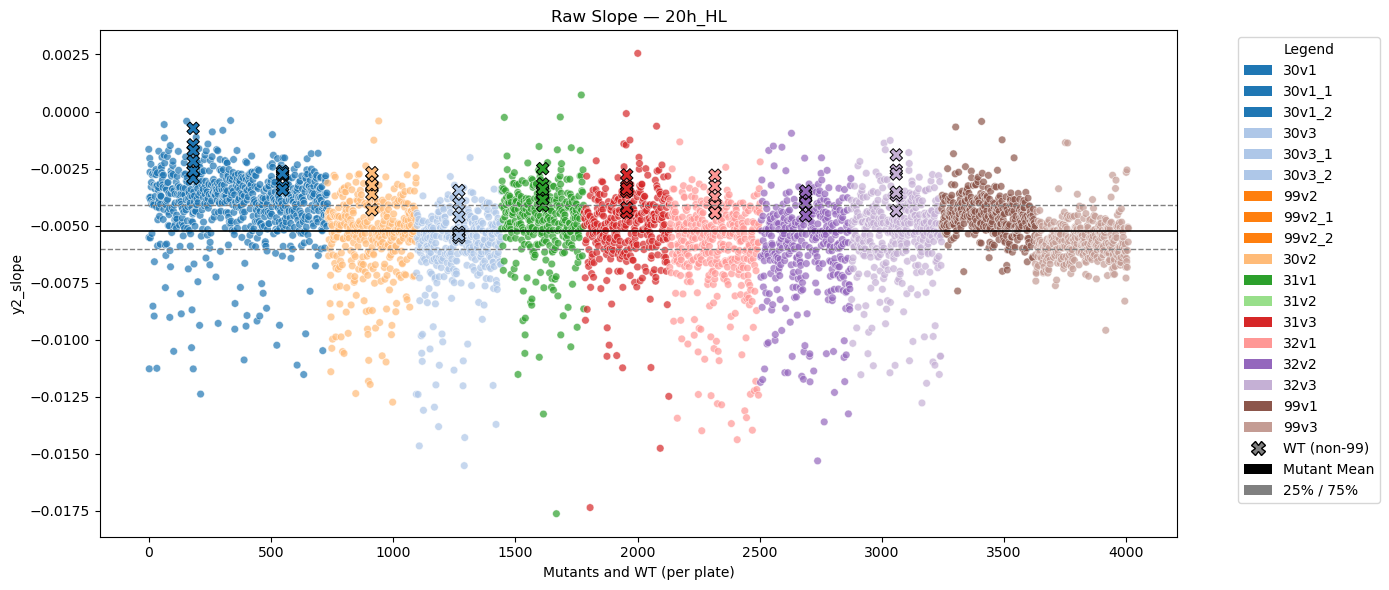

In [182]:

plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['20h_ML', '20h_HL']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)


    # sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    # sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope'].mean()
    q1 = sub_df['y2_slope'].quantile(0.25)
    q3 = sub_df['y2_slope'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Raw Slope — {regime}")
    plt.tight_layout()
    plt.show()


## compute two slopes

In [183]:
df_alter = phase2_df_new[phase2_df_new['light_regime'].isin(['2h-2h','10min-10min', '1min-1min', '30s-30s','5min-5min','1min-5min'])]
df_alter

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,elapsed_time_83,elapsed_time_84,elapsed_time_85,elapsed_time_86,elapsed_time_87,elapsed_time_88,elapsed_time_89,elapsed_time_90,y2_slope,y2_intercept
0,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,1,0.628277,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,0.000644,0.337564
1,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,3,0.555580,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,0.000620,0.294177
2,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,4,0.707976,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,-0.000841,0.443123
3,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,5,0.704442,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,-0.001784,0.419562
4,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,6,0.674942,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,-0.001743,0.396142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111925,99v3,M8,2024-11-12,5min-5min,15.920721,21.871672,180,15,18,0.650690,...,18.962222,19.045833,19.462778,19.546389,19.963333,20.046944,20.302778,NaN,-0.001876,0.374496
111926,99v3,M8,2024-11-12,5min-5min,15.920721,21.871672,180,15,19,0.605115,...,18.962222,19.045833,19.462778,19.546389,19.963333,20.046944,20.302778,NaN,-0.001855,0.355722
111927,99v3,M8,2024-11-12,5min-5min,15.920721,21.871672,180,15,20,0.623969,...,18.962222,19.045833,19.462778,19.546389,19.963333,20.046944,20.302778,NaN,-0.002854,0.387554
111928,99v3,M8,2024-11-12,5min-5min,15.920721,21.871672,180,15,21,0.639785,...,18.962222,19.045833,19.462778,19.546389,19.963333,20.046944,20.302778,NaN,-0.001778,0.372450


In [184]:
light_2h = pd.read_csv('Data light on off/20240917_99v1-M5_2h-2h.csv', sep=';')
light_2h = light_2h.loc[:, ~light_2h.columns.str.contains('^Unnamed')]
light_2h = light_2h.iloc[1:-1].reset_index(drop=True)

light_1min = pd.read_csv('Data light on off/20240913_99v1-M1_1min-1min.csv', sep=';')
light_1min = light_1min.loc[:, ~light_1min.columns.str.contains('^Unnamed')]
light_1min = light_1min.iloc[1:-1].reset_index(drop=True)

light_10min = pd.read_csv('Data light on off/20240919_99v1-M7_10min-10min.csv', sep=';')
light_10min = light_10min.loc[:, ~light_10min.columns.str.contains('^Unnamed')]
light_10min = light_10min.iloc[1:-1].reset_index(drop=True)

light_30s=pd.read_csv('Data light on off/20240918_99v1-M6_30s-30s.csv', sep=';')
light_30s = light_30s.loc[:, ~light_30s.columns.str.contains('^Unnamed')]
light_30s = light_30s.iloc[1:-1].reset_index(drop=True)

light_1min_5min = pd.read_csv('Data light on off/20240920_99v1-M8_1min-5min.csv', sep=';')
light_1min_5min = light_1min_5min.loc[:, ~light_1min_5min.columns.str.contains('^Unnamed')]
light_1min_5min = light_1min_5min.iloc[1:-1].reset_index(drop=True)

light_5min_5min = pd.read_csv('Data light on off/20241123_99v1-M8_5min-5min.csv', sep=';')
light_5min_5min = light_5min_5min.loc[:, ~light_5min_5min.columns.str.contains('^Unnamed')]
light_5min_5min = light_5min_5min.iloc[1:-1].reset_index(drop=True)

In [105]:
def feature_with_light_split(df, light_dict, n_timepoints_dict):
    """
    df: DataFrame in wide format (each row = one mutant)
    light_dict: dict mapping light_regime to corresponding light_XX DataFrame
    n_timepoints_dict: dict mapping light_regime to number of timepoints (40 or 80)
    """

    all_results = []

    for regime, group_df in df.groupby('light_regime'):
        
        if regime not in light_dict:
            continue  # skip if no light info provided for this regime

        light = light_dict[regime]
        n_timepoints = n_timepoints_dict[regime]

        # Extract ON/OFF mask
        par_values = light['PAR'].values[:n_timepoints]
        mask_on = par_values > 0
        mask_off = par_values == 0

        time_cols = [f'elapsed_time_{i}' for i in range(2, n_timepoints + 2)]
        y_cols = [f'y2_{i}' for i in range(1, n_timepoints + 1)]

        def compute_slopes(row):
            
            time_vals = row[time_cols].values.astype(float)
            y_vals = row[y_cols].values.astype(float)
        
            result = {
                'y2_slope_on': np.nan,
                'y2_intercept_on': np.nan,
                'y2_slope_off': np.nan,
                'y2_intercept_off': np.nan,
            }
        
            # ON
            # valid_on = mask_on & ~np.isnan(y_vals)
            valid_on = mask_on & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_on.sum() >= 2:
                model_on = LinearRegression()
                model_on.fit(time_vals[valid_on].reshape(-1, 1), y_vals[valid_on])
                result['y2_slope_on'] = model_on.coef_[0]
                result['y2_intercept_on'] = model_on.intercept_
        
            # OFF

            # valid_off = mask_off & ~np.isnan(y_vals)
            valid_off = mask_off & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_off.sum() >= 2:
                model_off = LinearRegression()
                model_off.fit(time_vals[valid_off].reshape(-1, 1), y_vals[valid_off])
                result['y2_slope_off'] = model_off.coef_[0]
                result['y2_intercept_off'] = model_off.intercept_
        
            return pd.Series(result)
        print(regime)

        slopes = group_df.apply(compute_slopes, axis=1)
        result = pd.concat([group_df, slopes], axis=1)
        #.reset_index(drop=True)
        all_results.append(result)

    # Combine results from all regimes
    return pd.concat(all_results, ignore_index=True)

In [185]:
light_dict = {
    '2h-2h': light_2h,
    '10min-10min': light_10min,
    '1min-1min': light_1min,
    '30s-30s': light_30s,
    '5min-5min':light_5min_5min,
    '1min-5min':light_1min_5min
}

n_timepoints_dict = {
    '2h-2h': 48,
    '10min-10min': 84,
    '1min-1min': 88,
    '30s-30s': 88,
    '5min-5min':88,
    '1min-5min':88
}



df1 = feature_with_light_split(df_alter, light_dict, n_timepoints_dict)

10min-10min
1min-1min
1min-5min
2h-2h
30s-30s
5min-5min


In [186]:
# Separate WT and mutants
wt_df =df1[df1['mutant_ID'] == 'WT']
mutant_df =df1[df1['mutant_ID'] != 'WT']

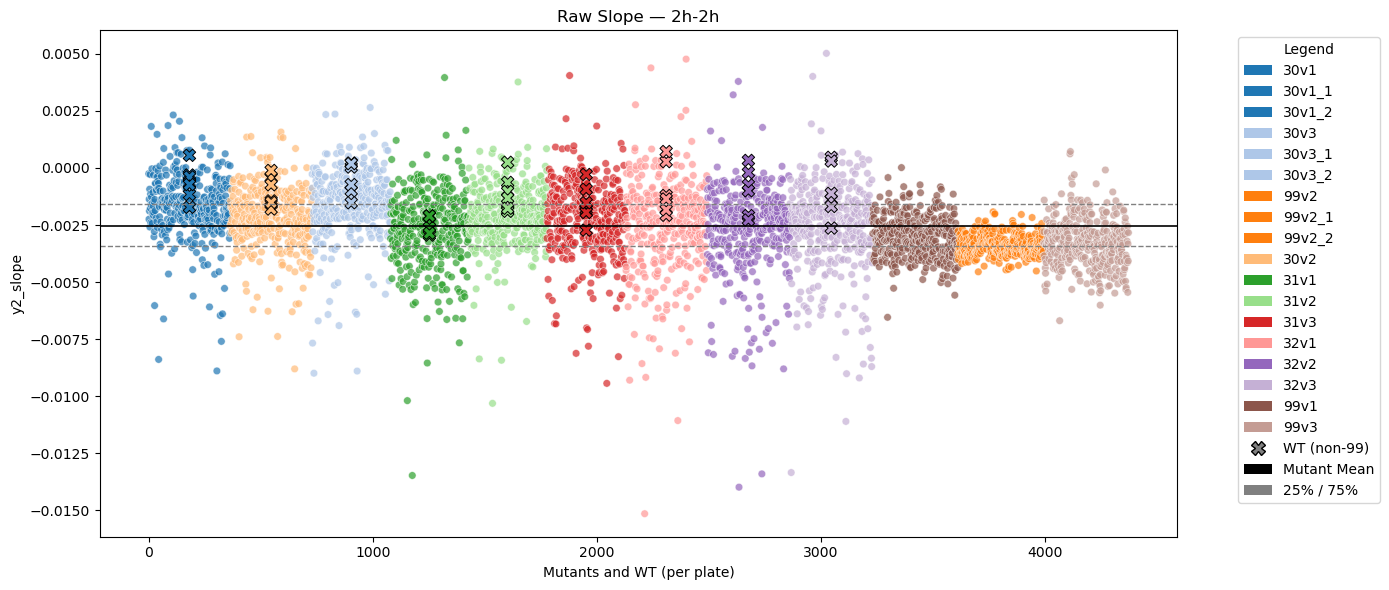

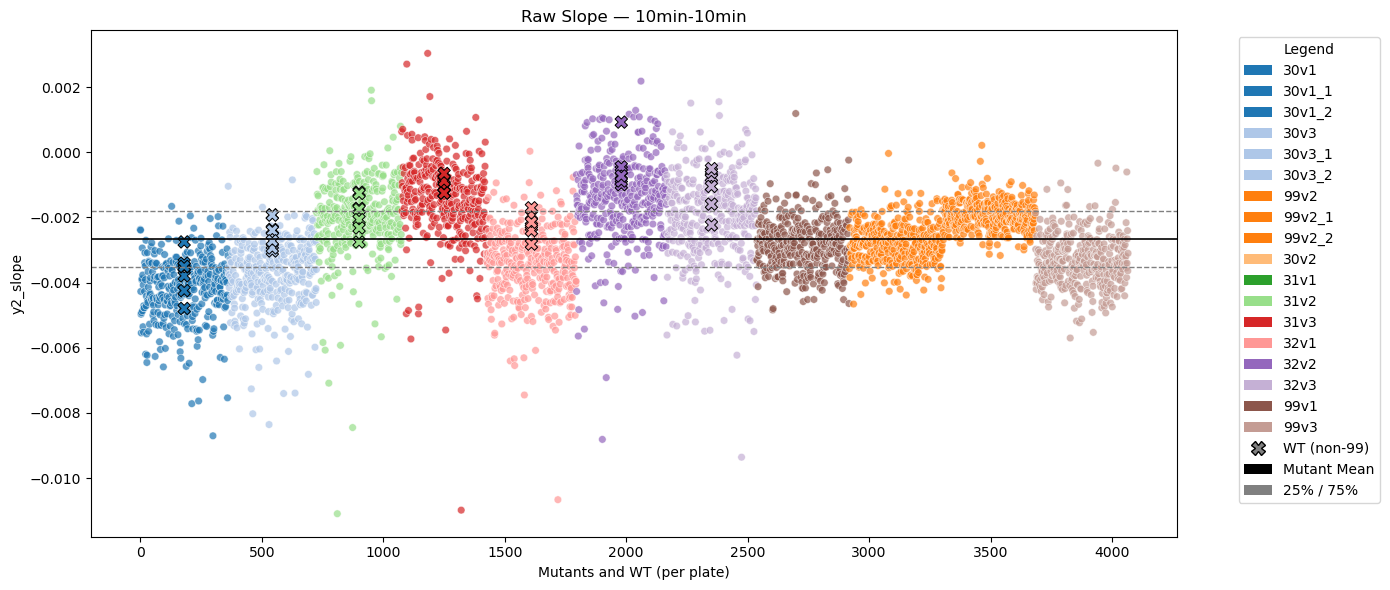

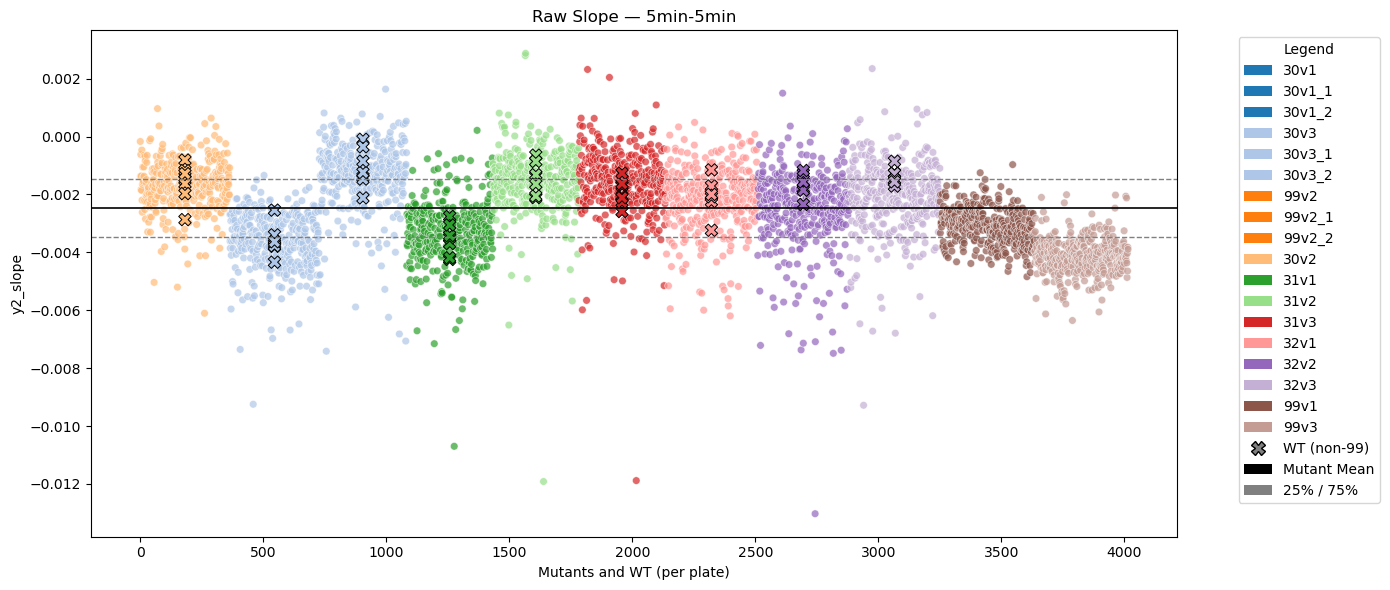

In [187]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['2h-2h','10min-10min', '5min-5min']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)


    # sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    # sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Raw Slope — {regime}")
    plt.tight_layout()
    plt.show()


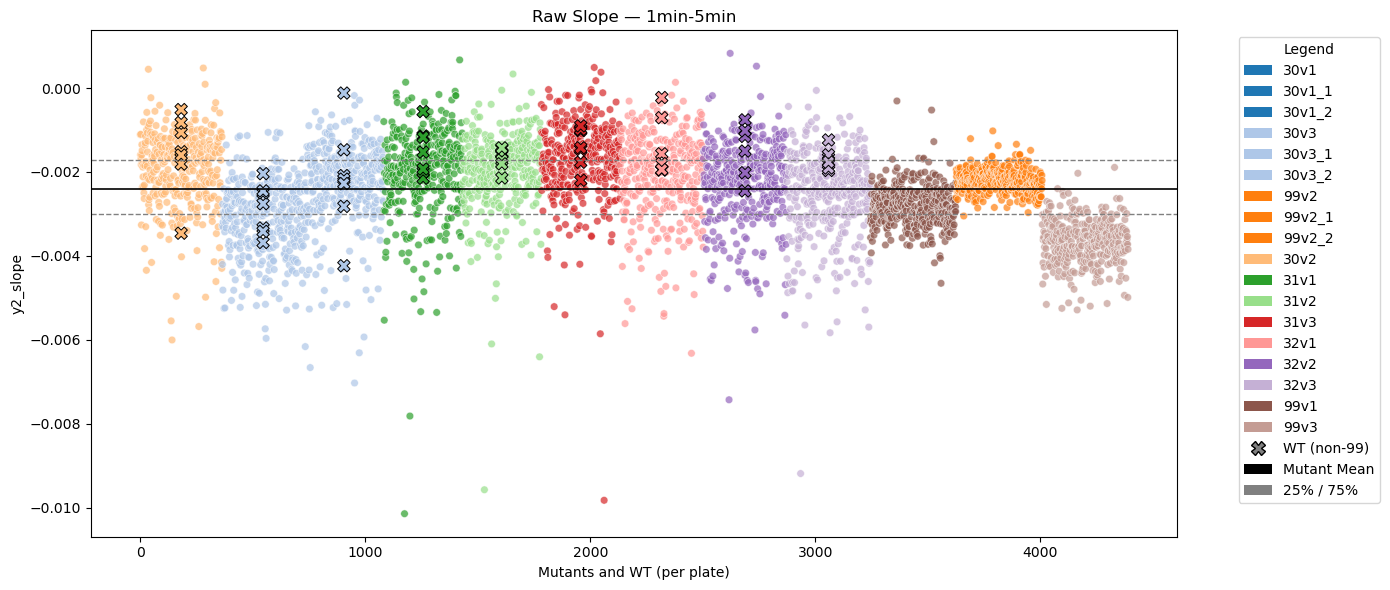

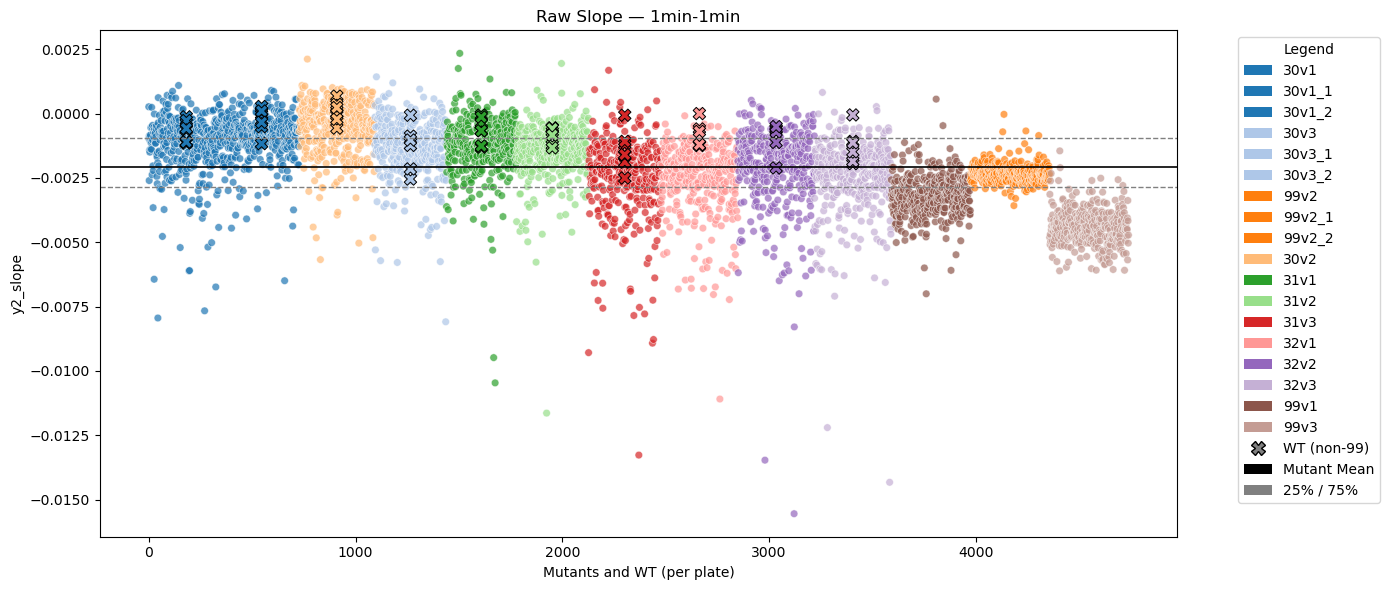

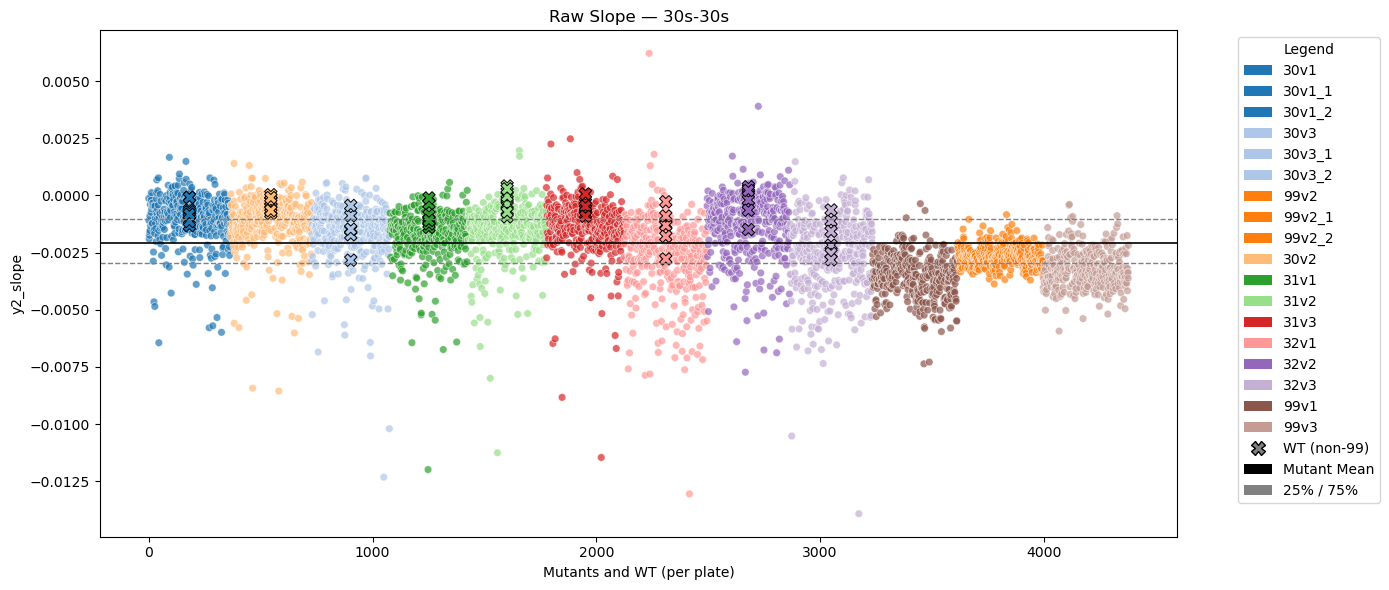

In [188]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['1min-5min','1min-1min', '30s-30s']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)


    # sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    # sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Raw Slope — {regime}")
    plt.tight_layout()
    plt.show()

In [189]:
alt_light_regimes = ['2h-2h', '10min-10min', '1min-1min', '30s-30s', '5min-5min', '1min-5min']

df_alt= df1.copy()  # includes extra columns
df_non_alt = phase2_df_new[~phase2_df_new['light_regime'].isin(alt_light_regimes)].copy()
for col in df_alt.columns:
    if col not in df_non_alt.columns:
        df_non_alt[col] = np.nan
df_non_alt = df_non_alt[df_alt.columns]
combined_df = pd.concat([df_alt, df_non_alt], ignore_index=True)
combined_df.shape

(34808, 824)

In [190]:
combined_df.to_csv('phase2_99_raw_slope(5.18)_newplate.csv',index=False)